# WET-007 Compare CWFS approaches with WET-001 LsstCam data

Last verified to run 2024/11/19

Versions:

* **lsst_distrib** w_2024_46 (ext, cvmfs)

* **ts_wep** v13.0.1 (commit c0670ffe)

This document compares using TIE and Danish to analyze simulated WET-001 data. Given the availability of the OPD ("truth"), goodness of fit is  measured by  the fidelity to the OPD. The simulation included 800 data references, i.e. 8 detectors (corner sensors) for 100 random optical states. This technote is part documentation describing a comparison between TIE and Danish (and ML in some cases) using simulated and observed data. The advantage of simulated data is a cleaner sample and exact knowledge of the input optical state in the form of OPD, thus enabling testing the comparison method. 

## Imports 

In [1]:
from lsst.daf import butler as dafButler
from lsst.ts.wep.task.generateDonutDirectDetectTask import (GenerateDonutDirectDetectTask,GenerateDonutDirectDetectTaskConfig)
from lsst.ts.wep.utils import convertZernikesToPsfWidth
from copy import copy
from lsst.obs.lsst import LsstCam
import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval
from matplotlib import colormaps as cmaps
import numpy as np
from astropy.io import fits 

## Ingest raws,  run ISR

Employ the central AOS butler repository. The simulated data was ingested with 

    butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_100/amp*

    butler define-visits /sdf/data/rubin/repo/aos_imsim   lsst.obs.lsst.LsstCam

    butler ingest-raws /sdf/data/rubin/repo/aos_imsim/ /sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_100/amp*

To run ISR, we use `bps condor` . 

Make `site_bps.yaml`, containing  


    site:
      s3df:
        profile:
          condor:
            +Walltime: 7200

Run 
    
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers

    bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim -i  LSSTCam/raw/all,LSSTCam/calib/unbounded -o WET-001_lsstCam_ISR -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineISRdoVar.yaml -d "instrument='LSSTCam' and exposure.science_program = 'wet001_100_dof_states'"

## Run donut detection in interactive mode to test sigma levels

We first run donut detection interactively for a single state to test the correct setting to use, for instance `config.measurementTask.nPixMinDetection`,  or `config.measurementTask.nSigmaDetection`. 



In [33]:
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['WET-001_lsstCam_ISR'],
    where=f"instrument='LSSTCam' and exposure.science_program = 'wet001_100_dof_states' \
    and exposure.seq_num = 2001 and detector = 192").expanded()
ref = list(dataRefs)[0]
exp = butler.get('postISRCCD', dataId = ref.dataId,  collections = ['WET-001_lsstCam_ISR'])

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 20 of 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 20 of 20 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/20 references


Text(0.5, 1.0, 'det 191')

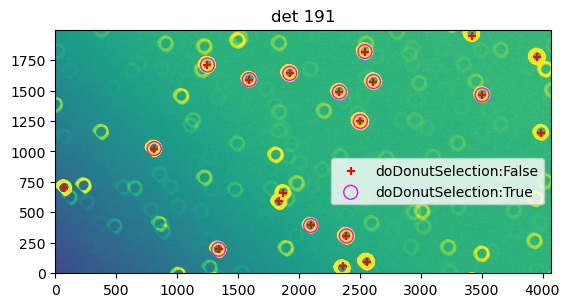

In [41]:
zscale = ZScaleInterval()

camera = LsstCam().getCamera()

config = GenerateDonutDirectDetectTaskConfig()
config.measurementTask.nSigmaDetection = 5
config.donutSelector.useCustomMagLimit = True

fig = plt.figure()

d = exp.image.array
vmin,vmax = zscale.get_limits(d)
plt.imshow(d, vmin=vmin, vmax=vmax, origin='lower')

# detect all donuts and overplot 
config.doDonutSelection = False

task = GenerateDonutDirectDetectTask(config=config)
taskOut = task.run(copy(exp), camera)
plt.scatter(taskOut.donutCatalog['centroid_x'], taskOut.donutCatalog['centroid_y'], 
            marker='+', c='r', label=f'doDonutSelection:{config.doDonutSelection}'
                )
# show the impact of turning on donut selector
config.doDonutSelection = True
task = GenerateDonutDirectDetectTask(config=config)
taskOut = task.run(copy(exp), camera)

plt.scatter(taskOut.donutCatalog['centroid_x'], taskOut.donutCatalog['centroid_y'], 
            marker='o', s=100, facecolors='none', edgecolors='magenta' ,label=f'doDonutSelection:{config.doDonutSelection}'
                )
plt.xlabel('x [px]')
plt.ylabel('y [px]')
plt.legend(bbox_to_anchor=[1.0,0.5])
plt.title(f'det {detId}')


Thus we see that $5\sigma$ threshold selects many donuts, while the effect of donut selector is the disappearance of donuts too close to the edge. 

## Run donut detection, cutouts, and Zernike estimation

We run each step separately, to be able to reuse the `postISRCCD`, `donutStampsExtra`, and `donutStampsIntra`. 

To run `bps` we need to run:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers
    lsst
    aos
    



In [81]:
isrCollection =     "WET-001_lsstCam_ISR"
cutoutsCollection = "WET-001_lsstCam_direct_stamps"
tieCollection =     "WET-001_lsstCam_direct_TIE1"
danishCollection =  "WET-001_lsstCam_direct_Danish1"

isrYaml = "lsstPipelineISRdoVar.yaml"
cutoutYaml = "lsstPipelineDirectCutoutOnly.yaml"
danishYaml = "lsstPipelineCalcDanishOnly.yaml"
tieYaml = "lsstPipelineCalcTieOnly.yaml"

pathCwd = '/sdf/group/rubin/shared/scichris/DM-46763_WET-007'
isrYamlPath = os.path.join(pathCwd, isrYaml)
cutoutYamlPath = os.path.join(pathCwd, cutoutYaml)
danishYamlPath = os.path.join(pathCwd, danishYaml)
tieYamlPath = os.path.join(pathCwd, tieYaml)

cmdCutout = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {isrCollection},LSSTCam/calib/unbounded \
-o {cutoutsCollection}  -p {cutoutYamlPath}"

cmdDanish = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {danishCollection}  -p {danishYamlPath} "

cmdTie = f"bps submit site_bps.yaml  -b  {butlerRootPath} -i {cutoutsCollection} \
-o {tieCollection}  -p {tieYamlPath}"

print(cmdCutout, "\n")
print(cmdDanish, "\n")
print(cmdTie, "\n")


bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstCam_ISR,LSSTCam/calib/unbounded -o WET-001_lsstCam_direct_stamps  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineDirectCutoutOnly.yaml 

bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstCam_direct_stamps -o WET-001_lsstCam_direct_Danish1  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineCalcDanishOnly.yaml  

bps submit site_bps.yaml  -b  /sdf/data/rubin/repo/aos_imsim/ -i WET-001_lsstCam_direct_stamps -o WET-001_lsstCam_direct_TIE1  -p /sdf/group/rubin/shared/scichris/DM-46763_WET-007/lsstPipelineCalcTieOnly.yaml 



The `lsstPipelineDirectCutoutOnly.yaml` contains:


    description: detect and cutout donuts
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutSelector.useCustomMagLimit: True
          measurementTask.nSigmaDetection: 5
      cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask


The `lsstPipelineCalcDanishOnly.yaml` contains:


    description: estimate Zk with Danish only
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
           python: |
              from lsst.ts.wep.task import  EstimateZernikesDanishTask
              config.estimateZernikes.retarget(EstimateZernikesDanishTask)
      aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
      aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask


The `lsstPipelineCalcTieOnly.yaml` contains:

    description: estimate Zk with TIE only
    instrument: lsst.obs.lsst.LsstCam
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
           python: |
              from lsst.ts.wep.task import EstimateZernikesTieTask
              config.estimateZernikes.retarget(EstimateZernikesTieTask)
      aggregateZernikesTask: lsst.donut.viz.AggregateZernikesTask
      aggregateDonutCatalogsTask: lsst.donut.viz.AggregateDonutCatalogsTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask



## Inspect the outputs

In [42]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
dataRefs = butler.registry.queryDatasets('donutStampsExtra', collections=['WET-001_lsstCam_direct_stamps'],
                             where=f"instrument='LSSTCam' and visit.seq_num = 2002").expanded()
ref = list(dataRefs)[0]

In [44]:
donutStampsExtra = butler.get('donutStampsExtra', dataId=ref.dataId, collections=['WET-001_lsstCam_direct_stamps'])

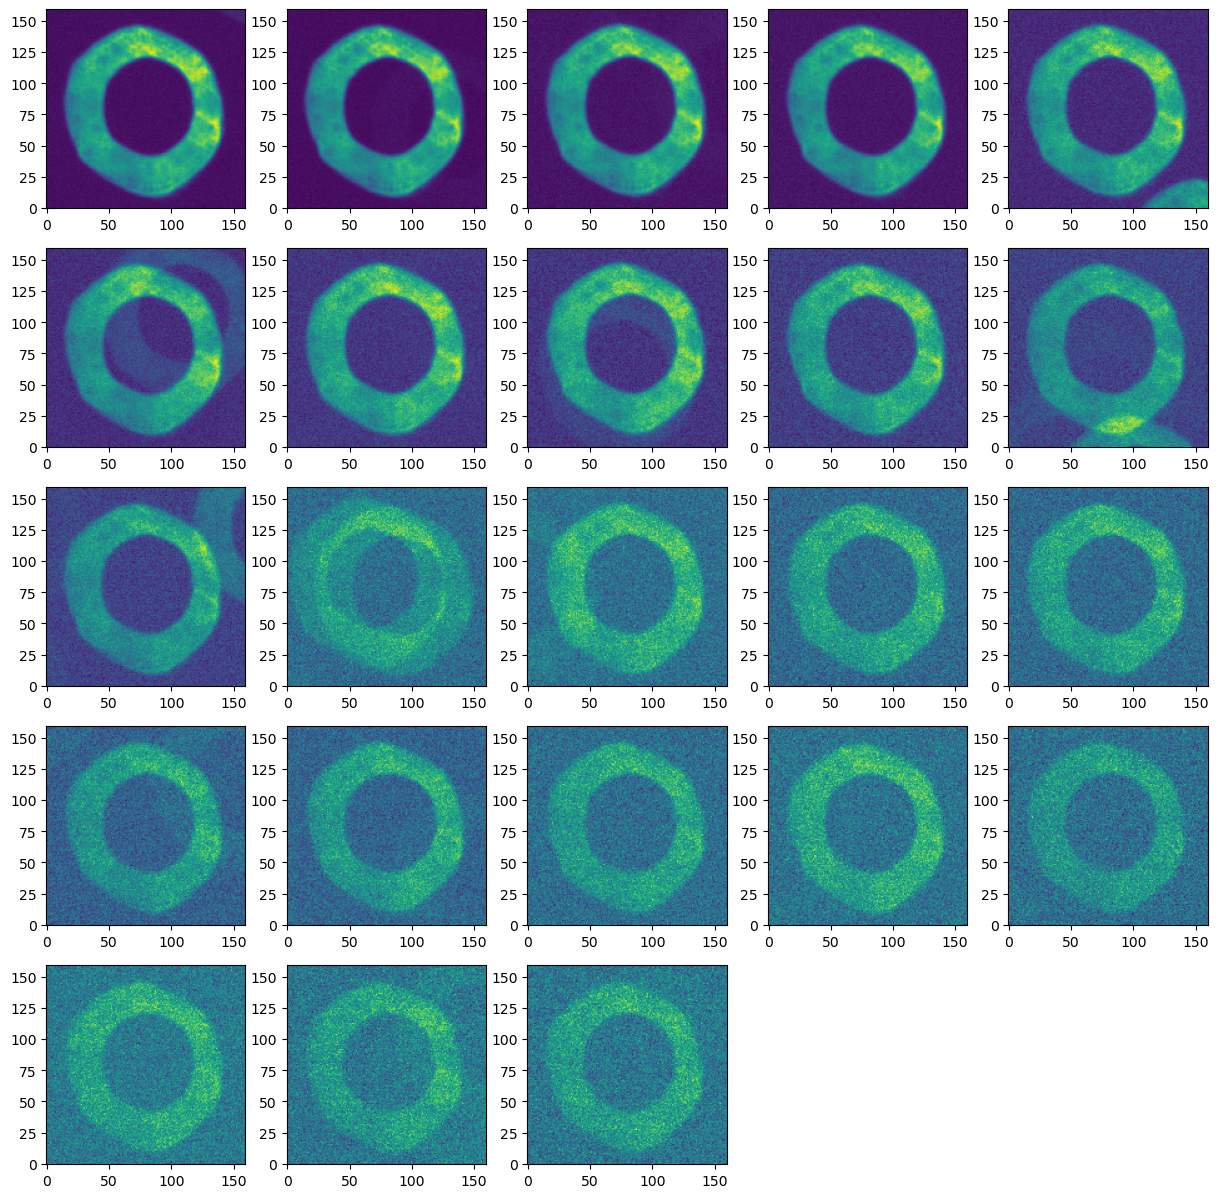

In [94]:
fig,axs = plt.subplots(5,5, figsize=(15,15))
ax = np.ravel(axs)
i=0
donutStamps = donutStampsExtra
for stamp in donutStamps:
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
    i += 1 
if len(donutStamps)<len(ax):
    for i in range(len(donutStamps), len(ax)):
        ax[i].axis('off')

## Check if all states have Zernike estimates 

In [46]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)

for method in ['Danish', 'TIE']:
    dataRefs = butler.registry.queryDatasets('zernikeEstimateRaw', collections=[f'WET-001_lsstCam_direct_{method}1'],
                                 where=f"instrument='LSSTCam' ").expanded()
    refs=[]
    for ref in dataRefs:
        refs.append(ref)
    n = len(refs)
    print(f'There are {n} Zk estimates for {method}')

There are 396 Zk estimates for Danish
There are 396 Zk estimates for TIE


Since there were 792 raw images, half (one Zk estimate per sensor pair) would be 396.

## Compare TIE to Danish

Read the OPD values :

In [50]:
# load all OPDs to a dict
all_opd = {}
for n in range(1,101):
    opdDir = f'/sdf/data/rubin/user/gmegias/projects/commissioning_sims/WET-001_lsstcam/state_{n}'

    hdul = fits.open(os.path.join(opdDir,'opd.fits'))

    
    opds = {}
    for i in range(len(hdul)):
        opd_zks_1_28 = []
        for key,value in hdul[i].header.items():
            
            if key.startswith('AZ'):
                #print(key.split('_')[1])
                opd_zks_1_28.append(value)
        opds[i] = opd_zks_1_28
    all_opd[n]  = opds
    
opd_raft_to_id = {'R00':0, 'R04':1, 'R40':2, 'R44':3}  


Read the results:

In [36]:
butlerRootPath = '/sdf/data/rubin/repo/aos_imsim/'
butler = dafButler.Butler(butlerRootPath)
registry = butler.registry
output_collection = 'WET-001_lsstCam_direct_TIE1'
dataRefs = list(registry.queryDatasets('donutStampsExtra', collections=[output_collection],
                                     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' ").expanded())

print(len(dataRefs))

396


In [38]:
results = {'tie':{}, 'danish':{}}
for method in results.keys():
    results[method] = {}
    for state in range(1,100):
        results[method][state] = {}
        
for ref in dataRefs:
    # read in the results of each method 
    for method in results.keys():
        if method == 'tie':
            coll_method = 'TIE'  
        else:
            coll_method = 'Danish'
        coll = f'WET-001_lsstCam_direct_{coll_method}1'
        state = int(str(ref.dataId.visit.id)[-3:]) 
        raft = ref.dataId.detector.raft
        
        results[method][state][raft] =  butler.get('zernikeEstimateAvg', 
                          dataId=ref.dataId, 
                          collections=[coll])

Compare TIE to Danish:

In [54]:
def plot_lsstcam_fit_vs_opd(state, opd_raft_to_id, all_opd, results, plot_asec=False):
    rafts = ['R04', 'R44', 'R00','R40']
    fig,axs = plt.subplots(2,2,figsize=(16,8))
    ax = np.ravel(axs)
    i=0
    
    # this plots  just the pairing results 
    colors = {'danish':'green',  'tie':'orange'}
    for raft in rafts:
        
        ax[i].set_title(raft )
        opdId = opd_raft_to_id[raft] 
        opd_zk = 0.001*np.array(all_opd[state][opdId][3:29])
        dFWHMtrue = convertZernikesToPsfWidth(opd_zk)
        for method in results.keys():
            avg_zk = results[method][state][raft][0]

            # Convert Zernikes to image quality contribution (asec) with `convertZernikesToPsfWidth`
            if plot_asec:
                dFWHMfit = convertZernikesToPsfWidth(avg_zk)
                diffFWHM = dFWHMfit - dFWHMtrue
                psfDegradation = np.sqrt(np.sum(np.square(diffFWHM)))
                ax[i].plot(np.arange(4,29), diffFWHM, marker='d', label=f'{method} PSF FWHM degradation {psfDegradation:.3f} asec')
            else:
                diff_zk = avg_zk-opd_zk
                rms_diff_avg =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
                ax[i].plot(np.arange(4,29), diff_zk, marker='d', label=f'{method} $\Delta$rms={rms_diff_avg:.3f} microns')
        if plot_asec:
            ax[i].set_ylabel(r'$\Delta$ (PSF fit - PSF OPD) [asec]')
        else:
            ax[i].set_ylabel(r'$\Delta$ (fit-OPD) [microns]')
        ax[i].set_xlabel('Zk mode')
        ax[i].set_xticks(np.arange(4,29,step=2))
        ax[i].axhline(0,ls='--', c='red')
        ax[i].legend()
        i+=1
       
    
    fig.subplots_adjust(hspace=0.3)
    fig.suptitle(f'WE7-007 lsstCam, state {state}:, \n TIE vs Danish')

Plot comparison between TIE and Danish, showing the difference from the OPD for a single state:

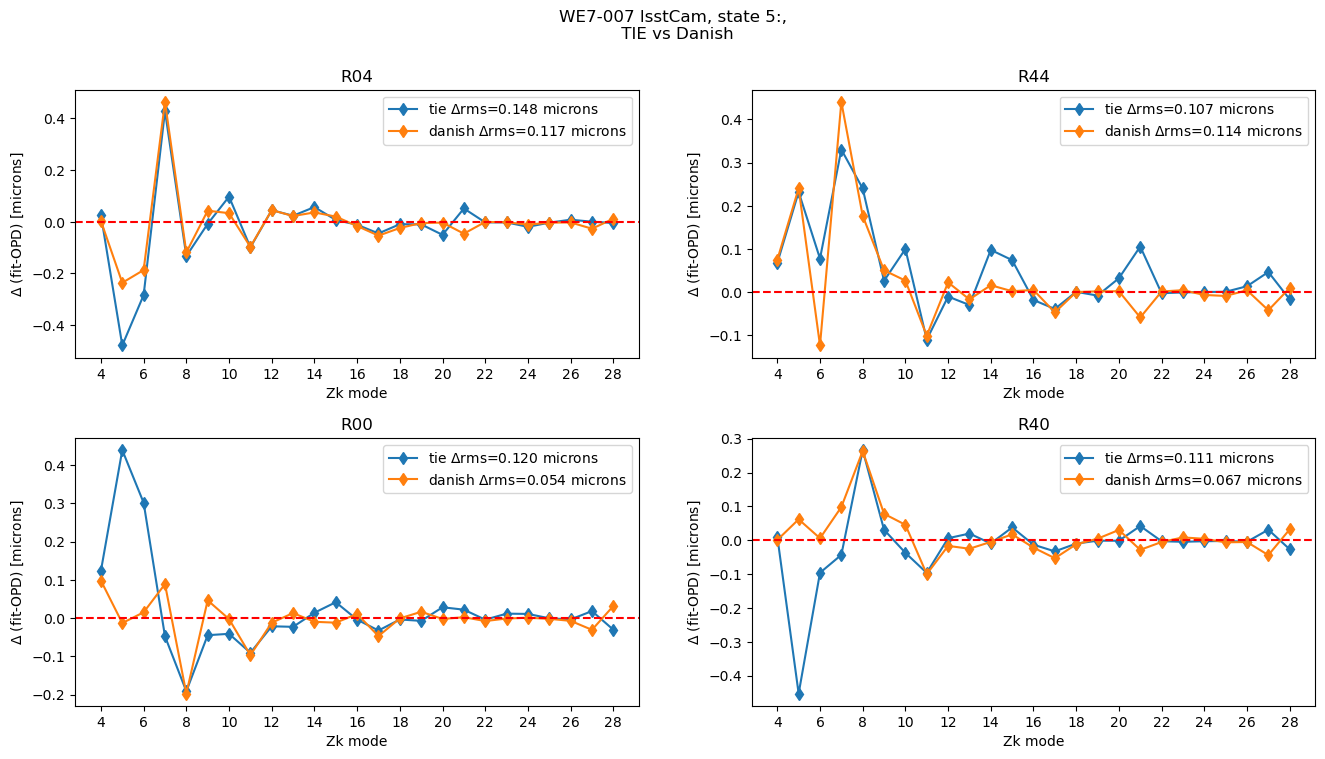

In [55]:
plot_lsstcam_fit_vs_opd(5, opd_raft_to_id, all_opd, results)

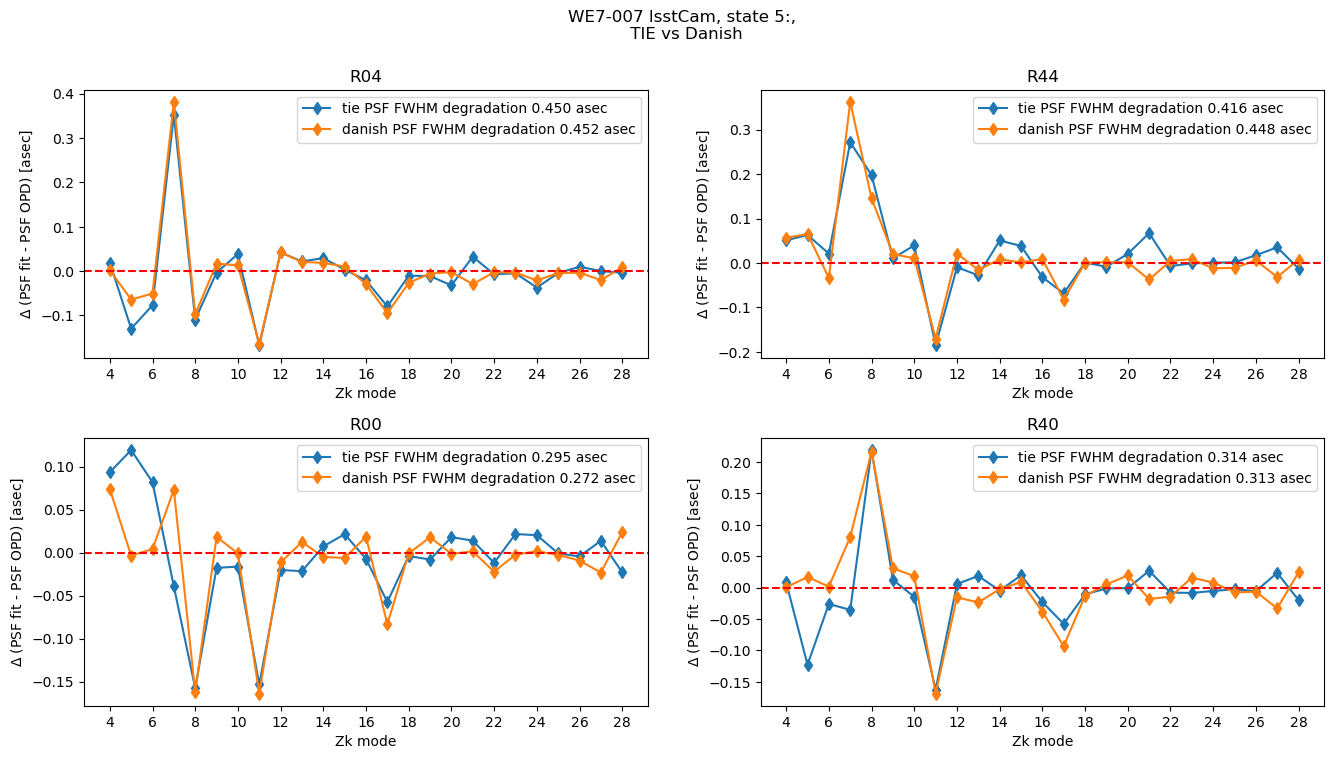

In [56]:
plot_lsstcam_fit_vs_opd(5, opd_raft_to_id, all_opd, results, plot_asec=True)

For each state we have one RMS difference between fitted value and the  OPD:
$$
\begin{equation}
\Delta \mathrm{rms} =  \sqrt{\langle (zk_{\mathrm{fit}}-zk_{\mathrm{OPD}})^2  \rangle }
\end{equation}                
$$ 

The PSF FWHM degradation is the AOS contribution, i.e. degradation with respect to the optimal PSF:
$$
\begin{equation}
\mathrm{psfDegradation} = \sqrt{\sum_{i}{(\mathrm{dFWHMopd} - \mathrm{dFWHMfit})^2}}
\end{equation}                
$$               
where we sum over all available Zernike modes. We can calculate both quantities for all states:

In [60]:
rmss={}
psfDeg={}
rafts = ['R04', 'R44', 'R00','R40']
# add pairing results 
for algo in results.keys():
   rmss[algo] = {}
   psfDeg[algo]={}
   for raft in rafts:
       rmss[algo][raft] = []
       psfDeg[algo][raft] = []
       opdId = opd_raft_to_id[raft] 
       for state in results[algo].keys():
            opd_zk = 0.001*np.array(all_opd[state][opdId][3:29])
            avg_zk = np.mean(results[algo][state][raft], axis=0)
            rms_diff =  np.sqrt(np.mean(np.square(avg_zk-opd_zk)))
            rmss[algo][raft].append(rms_diff)
            
            dFWHMtrue = convertZernikesToPsfWidth(opd_zk)
            dFWHMfit = convertZernikesToPsfWidth(avg_zk)
            diffFWHM = dFWHMfit - dFWHMtrue
            psfDegradation = np.sqrt(np.sum(np.square(diffFWHM)))
            psfDeg[algo][raft].append(psfDegradation)
       
            if rms_diff > 10:
                print(algo, raft, state, rms_diff)

tie R04 45 1289.5422211020345
tie R44 45 113.45955258359294
tie R00 45 251.4142584734439
tie R40 45 101.10504202327914


Plot a summary RMS difference per state for all states: this highlights if there is any particular optical state that either algorithm performed more poorly:

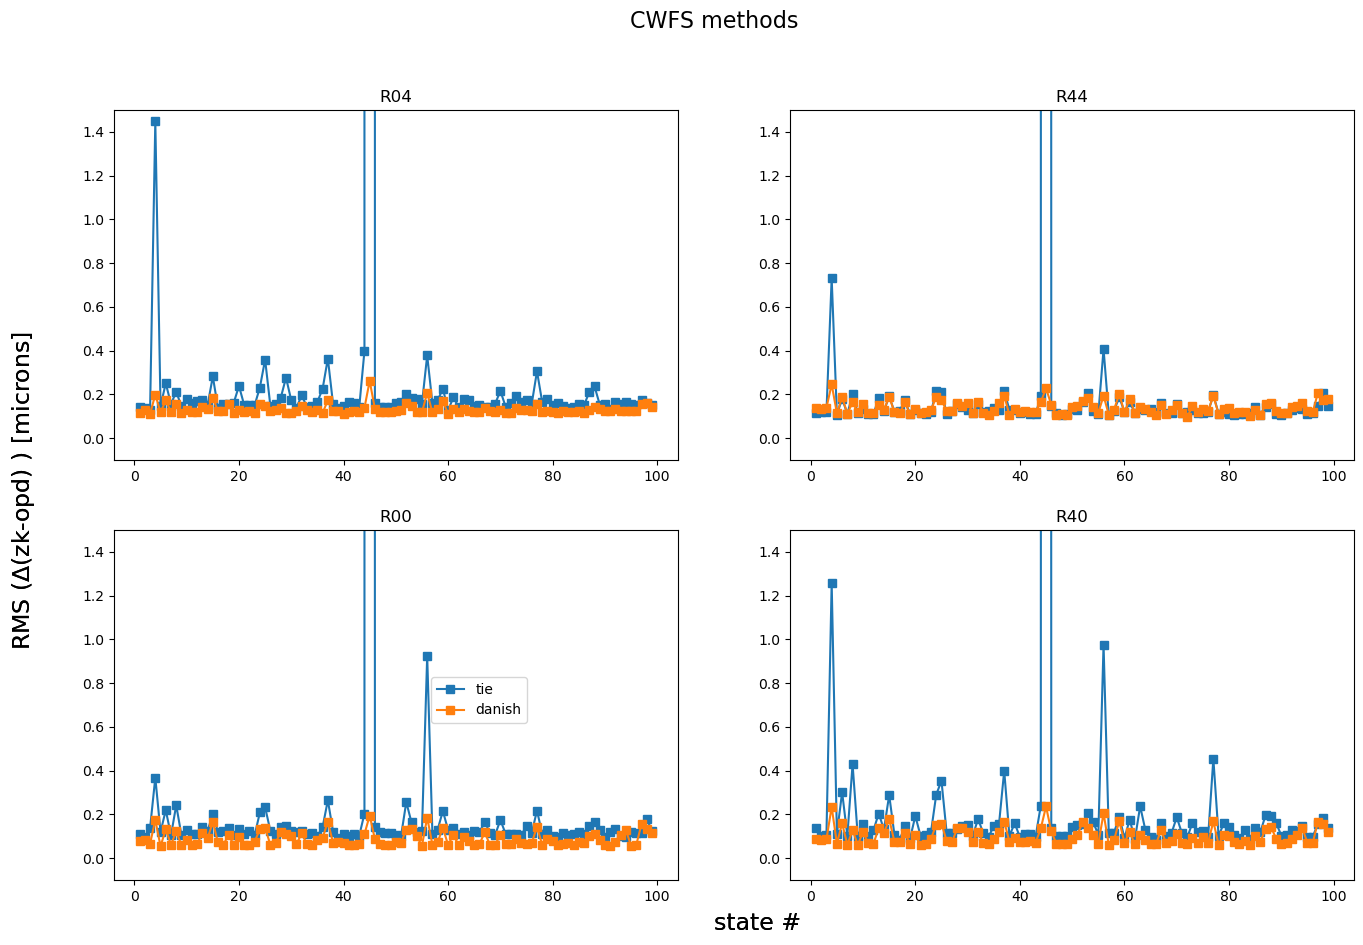

In [69]:
fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)

for method in rmss.keys():
    i=0
    for raft in rafts:
        ax[i].plot(results[algo].keys(), rmss[method][raft], marker='s', label=f'{method}')
        ax[i].set_title(raft)
        ax[i].set_ylim(-0.1,1.5)
        i+=1
   
    fig.text(0.5,0.06,'state #', fontsize=17)
    fig.text(0.06,0.5,r'RMS ($\Delta$(zk-opd) ) [microns] ', rotation=90, fontsize=17, va='center')
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

Also plot the AOS contribution to PSF degradation:

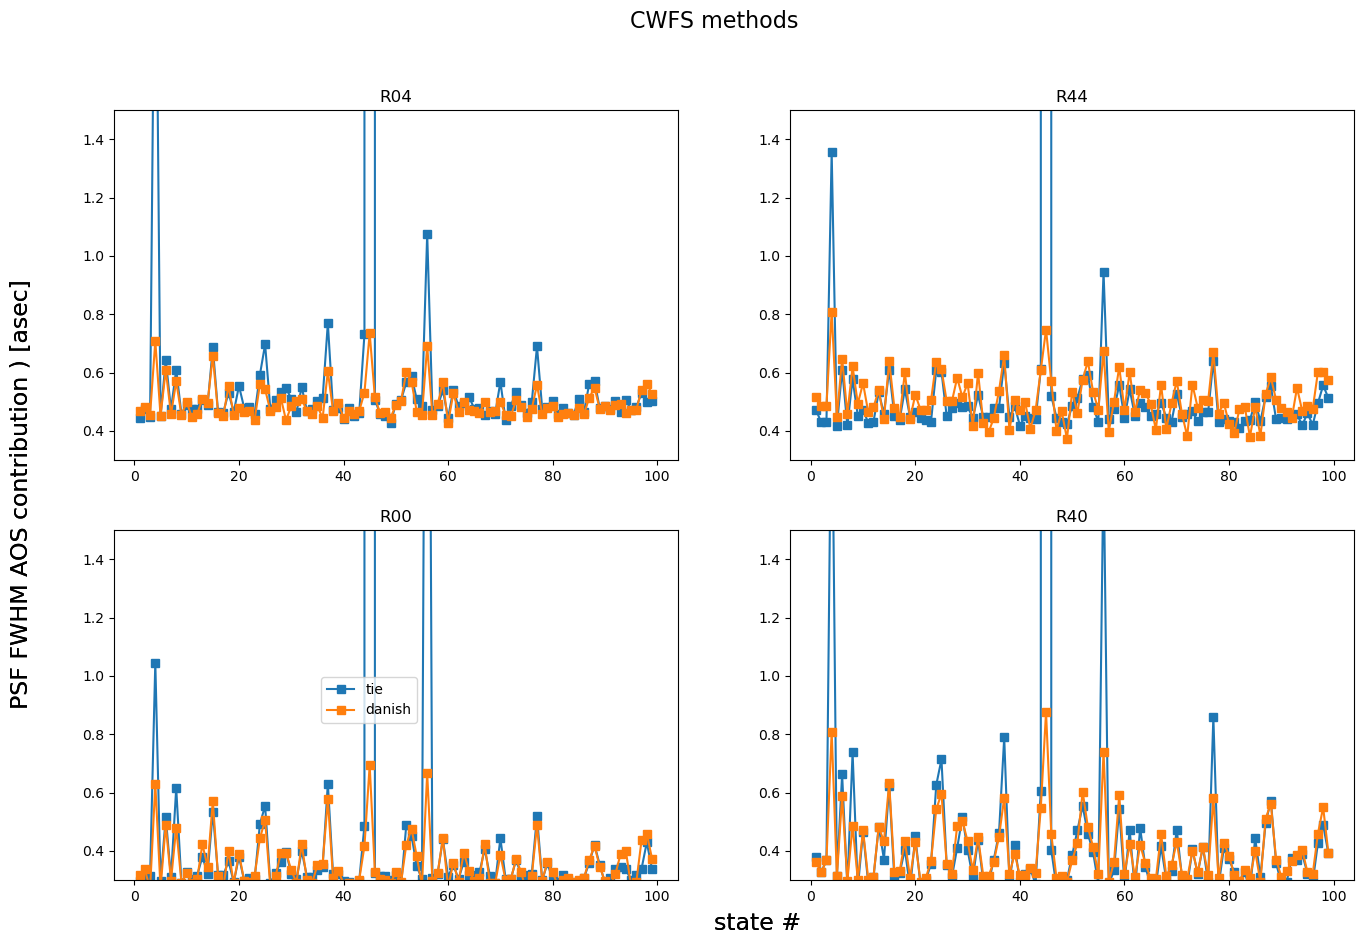

In [68]:
fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)

for method in rmss.keys():
    i=0
    for raft in rafts:
        ax[i].plot(results[algo].keys(), psfDeg[method][raft], marker='s', label=f'{method}')
        ax[i].set_title(raft)
        ax[i].set_ylim(0.3,1.5)
        i+=1
   
    fig.text(0.5,0.06,'state #', fontsize=17)
    fig.text(0.06,0.5, r'PSF FWHM AOS contribution ) [asec] ', rotation=90, fontsize=17, va='center')
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

This shows that there is a state (possibly a few) that's worse than others. Plot everything apart from that state:

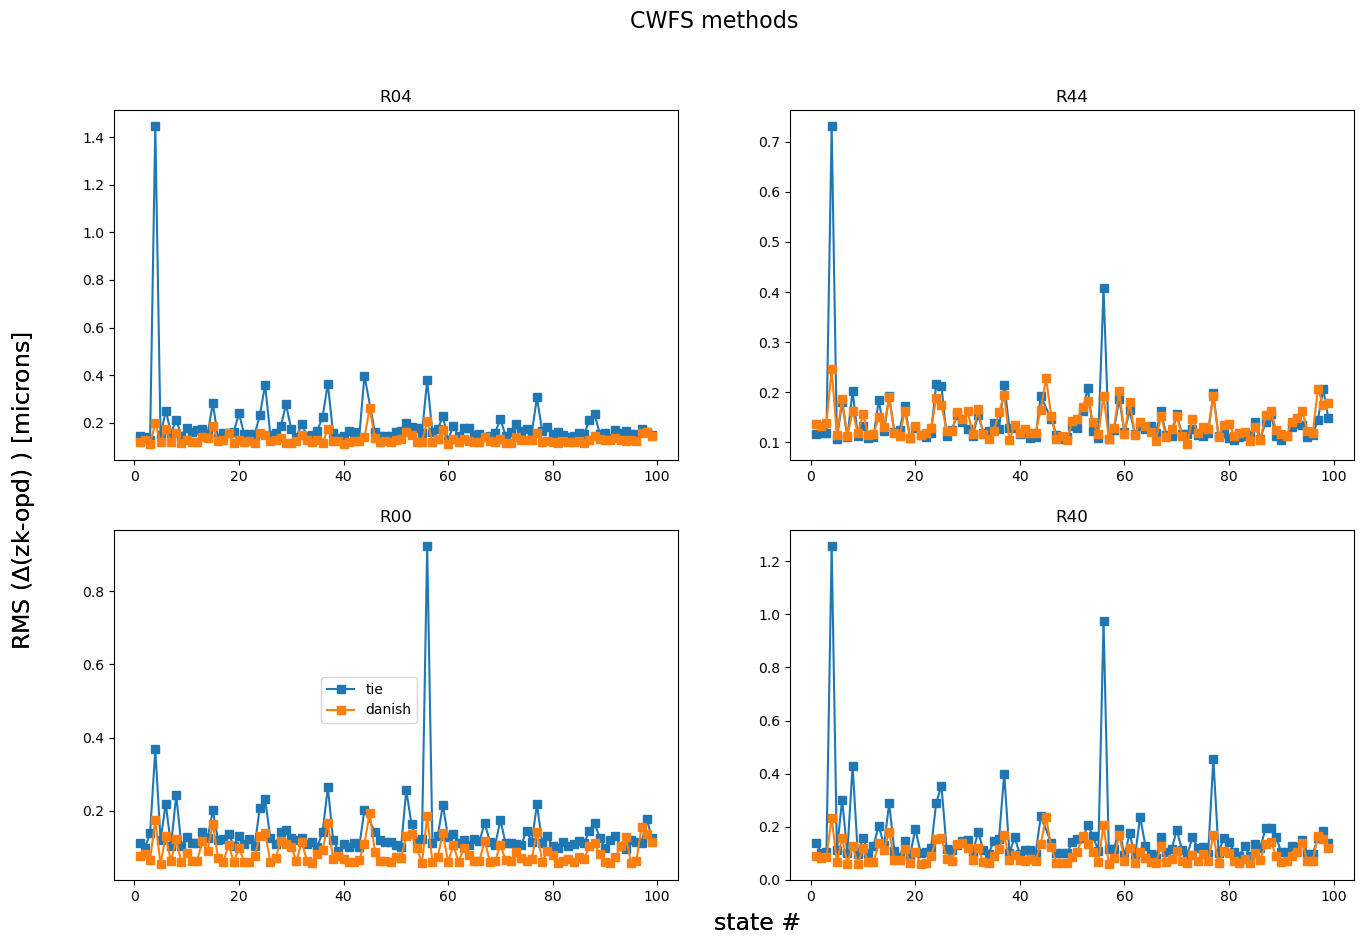

In [70]:
fig,axs = plt.subplots(2,2,figsize=(16,10))
ax = np.ravel(axs)


for method in rmss.keys():
    i=0
    for raft in rafts:
        mask = np.array(rmss[method][raft]) < 10
        states_select = np.array(list(results[method].keys()))[mask]
        rmss_select = np.array(rmss[method][raft])[mask]
        ax[i].plot(states_select, rmss_select, marker='s', label=f'{method}')
        ax[i].set_title(raft)
        i+=1
    
    fig.text(0.5,0.06,'state #', fontsize=17)
    fig.text(0.06,0.5,r'RMS ($\Delta$(zk-opd) ) [microns] ', rotation=90, fontsize=17, va='center')
fig.suptitle('CWFS methods', fontsize=16)
ax[2].legend(bbox_to_anchor=[0.55,.6])

Focus on the errant state:

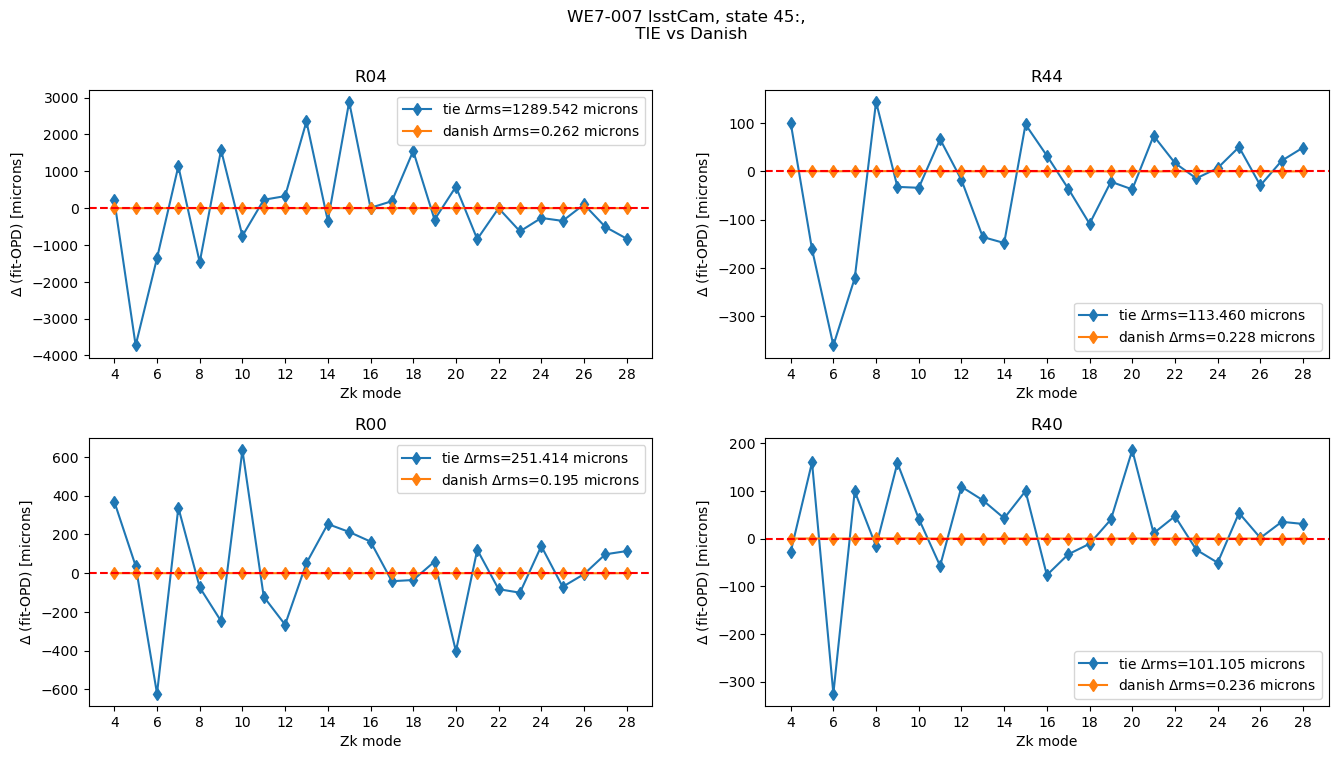

In [71]:
plot_lsstcam_fit_vs_opd(45, opd_raft_to_id, all_opd, results)

We see that while Danish has a result close to OPD, TIE is definitely suffering from a bad fit.   Show the stamps used:

In [72]:
refs = list(registry.queryDatasets('donutStampsExtra', collections=[ 'WET-001_lsstCam_direct_TIE1'],
     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' and visit.seq_num = 2045").expanded())
zkRaw = butler.get('zernikeEstimateRaw', dataId= refs[0].dataId, collections=['WET-001_lsstCam_direct_TIE1'])
zkRaw1 = butler.get('zernikeEstimateRaw', dataId= refs[0].dataId, collections=['WET-001_lsstCam_direct_Danish1'])

In [75]:
zkRaw[0]

array([-1.42689246e+01, -5.51136728e-01,  9.57510874e+01,  3.29284421e+00,
        9.62738958e+00,  4.07373023e+00, -3.89940463e+01,  3.44553603e-01,
       -1.48137946e+01,  1.52848648e+01, -1.34964708e+01, -1.59358651e+01,
        4.72314172e-02, -7.45705165e+00,  9.54004421e-01,  1.35170286e+01,
        1.51944589e+00,  1.87912801e+00,  3.71520720e+00, -3.81286751e+00,
        5.28509294e+00,  6.23561188e+00,  2.34519833e+01, -5.02607643e+00,
       -3.11757073e+01])

So these are gigantic values (in microns) ! Show the postISRCCD

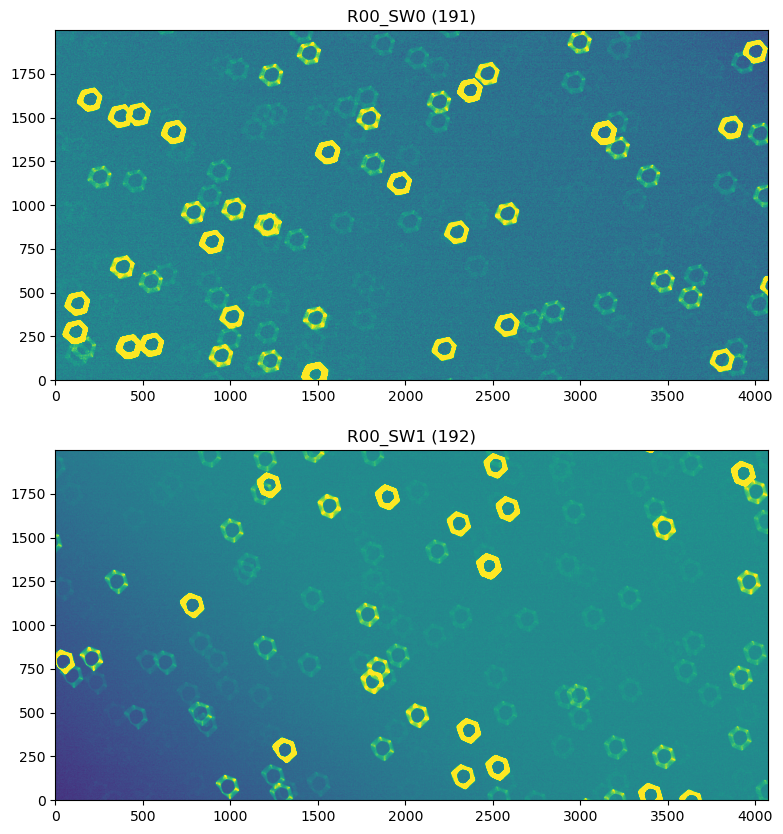

In [16]:
dataIdExtra= {'instrument':'LSSTCam',
'detector':191,
'exposure':5024072302045,
'day_obs':20240723
         }
dataIdIntra= {'instrument':'LSSTCam',
'detector':192,
'exposure':5024072302045,
'day_obs':20240723
         }

exposureExtra = butler.get('postISRCCD', dataId = dataIdExtra, collections=['WET-001_lsstCam_ISR'])
exposureIntra = butler.get('postISRCCD', dataId = dataIdIntra, collections=['WET-001_lsstCam_ISR'])
fig,ax = plt.subplots(2,1,figsize=(10,10))
k=0
for exposure in [exposureExtra,exposureIntra]:
    zscale = ZScaleInterval()
    d = exposure.image.array
    vmin,vmax = zscale.get_limits(d)
    ax[k].imshow(d, vmin=vmin,vmax=vmax, origin='lower')
    ax[k].set_title(f'{exposure.getDetector().getName()} ({exposure.getDetector().getId()})')
    k+=1 


Compare the extra and intra-focal donuts 

In [26]:
dataRefs = registry.queryDatasets('donutStampsExtra', collections=[ 'WET-001_lsstCam_direct_TIE1'],
     where=f"instrument='LSSTCam' and detector.purpose='WAVEFRONT' and visit.seq_num = 2045").expanded()
refs = list(dataRefs)
donutStampsExtra = butler.get('donutStampsExtra', dataId=refs[0].dataId, collections=['WET-001_lsstCam_direct_TIE1'])
donutStampsIntra = butler.get('donutStampsIntra', dataId=refs[0].dataId, collections=['WET-001_lsstCam_direct_TIE1'])

Text(0.5, 1.0, 'intra')

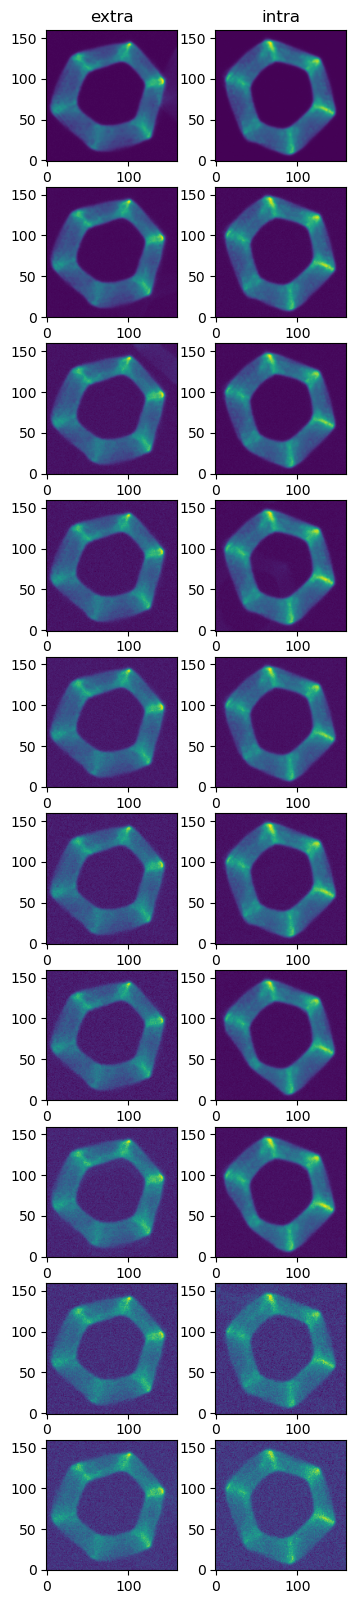

In [33]:
nrows=10; ncols=2
w=2
fig,ax = plt.subplots(nrows,ncols, figsize=(ncols*w, nrows*w))
for i in range(10):
    de = donutStampsExtra[i]
    di = donutStampsIntra[i]
    ax[i,0].imshow(de.stamp_im.image.array, origin='lower')
    ax[i,1].imshow(di.stamp_im.image.array, origin='lower')
ax[0,0].set_title('extra')
ax[0,1].set_title('intra')

Show OPD and Zernike fits for that exposure:

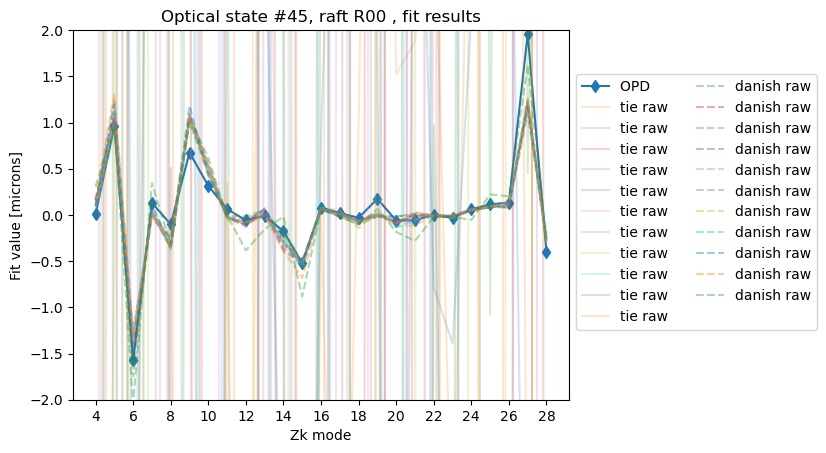

In [80]:
raft = refs[0].dataId.detector.raft
state = 45 
fig,ax = plt.subplots()

ax.set_title(f'Optical state #{state}, raft {raft} , fit results' )
opdId = opd_raft_to_id[raft] 
opd_zk = 0.001*np.array(all_opd[state][opdId][3:29])

ax.plot(np.arange(4,29), opd_zk, marker='d', label=f'OPD ')

# plot raw TIE
for i in range(len(zkRaw)):
   ax.plot(np.arange(4,29),zkRaw[i], alpha=0.2, label=f'tie raw')

# plot raw Danish 
for i in range(len(zkRaw1)):
   ax.plot(np.arange(4,29),zkRaw1[i], alpha=0.4,  ls='--',  label=f'danish raw')

ax.set_ylim(-2,2)
  
ax.set_ylabel(r'Fit value [microns]')
ax.set_xlabel('Zk mode')
ax.set_xticks(np.arange(4,29,step=2))
ax.legend(bbox_to_anchor=[1.0,0.9], ncols=2)



So for TIE all donut estimates  for that state are exceptionally bad. 

Marginalize across all detectors:

In [76]:
mean_per_state = {}
mean_per_state_psf = {}
for method in rmss.keys():
    all_raft_data = []
    all_raft_data_psf = []
    for raft in rafts:
        all_raft_data.append( rmss[method][raft])
        all_raft_data_psf.append(psfDeg[method][raft])
    mean_per_state[method] = np.mean(all_raft_data, axis=0)
    mean_per_state_psf[method] = np.mean(all_raft_data_psf, axis=0)

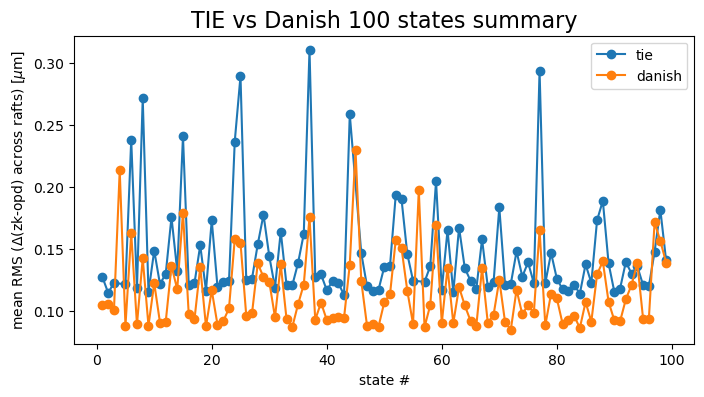

In [78]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
j=0
cmap = cmaps['tab10']
for method in mean_per_state.keys():
    mask = np.array(rmss[method][raft]) < 0.5
    states_select = np.array(list(results[method].keys()))[mask]
    mean_select = mean_per_state[method][mask]
    ax.plot(states_select,mean_select, marker='o', label=f'{method}',
           c=cmap(j))
    j+=1
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RMS ($\Delta$(zk-opd) across rafts) '+r'[$\mu$m]',)
ax.set_title('TIE vs Danish 100 states summary', fontsize=16)
ax.legend()

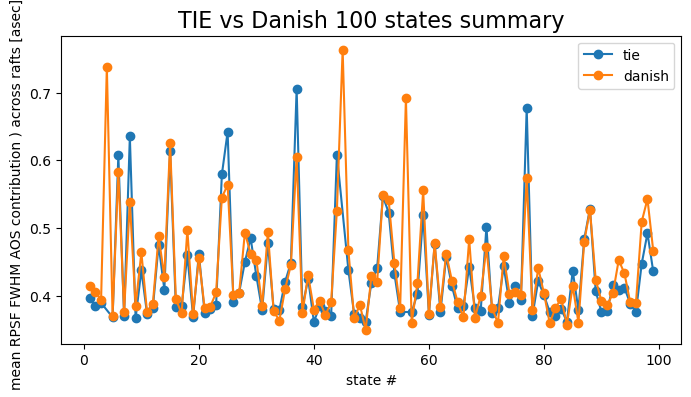

In [79]:
fig,ax = plt.subplots(1,1,figsize=(8,4))
j=0
cmap = cmaps['tab10']
for method in mean_per_state.keys():
    mask = np.array(psfDeg[method][raft]) < 1
    states_select = np.array(list(results[method].keys()))[mask]
    mean_select = mean_per_state_psf[method][mask]
    ax.plot(states_select, mean_select, marker='o', label=f'{method}',
           c=cmap(j))
    j+=1
ax.set_xlabel('state #')
ax.set_ylabel(r'mean RPSF FWHM AOS contribution ) across rafts [asec]  ')
ax.set_title('TIE vs Danish 100 states summary', fontsize=16)
ax.legend()

This shows that for majority of simulated states, Danish performs better than TIE in terms of an absolute fit value compared to the OPD in microns. However, when converted to PSDF degradation, the difference is not as clear cut. Choice between Danish and TIE would need to consider the fit accuracy and robustness to outliers (eg. here for state 45  Danish was immune to being provided very distorted donuts). 